## Prophet 

***Importando as bibliotecas***

In [1]:
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import datetime as dt
import warnings

warnings.filterwarnings("ignore")

### Lendo a base (Histórico de preços da Gerdau)

In [2]:
def extract_data_qt(quote):
    yf.pdr_override()
    df = web.get_data_yahoo(quote, period='5y', rounding=True)
    return df

In [3]:
df_gerdau = extract_data_qt('GGBR4.SA')

[*********************100%***********************]  1 of 1 completed


In [4]:
df = df_gerdau[['Close']]
df['ds'] = df.index
df = df.rename(columns={"Close": "y"})

#### Criando o modelo Prophet

In [5]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Definindo o tempo futuro 30 dias

In [6]:
future = m.make_future_dataframe(periods=30)
future = future[future['ds'].dt.dayofweek < 5]

#### Realizano a predição

In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1260,2020-09-04,15.712311,13.584770,17.720136
1261,2020-09-07,15.778337,13.810641,17.959480
1262,2020-09-08,15.793069,13.740592,17.811050
1263,2020-09-09,15.813152,13.691048,17.960931
1264,2020-09-10,15.843285,13.718740,17.786778


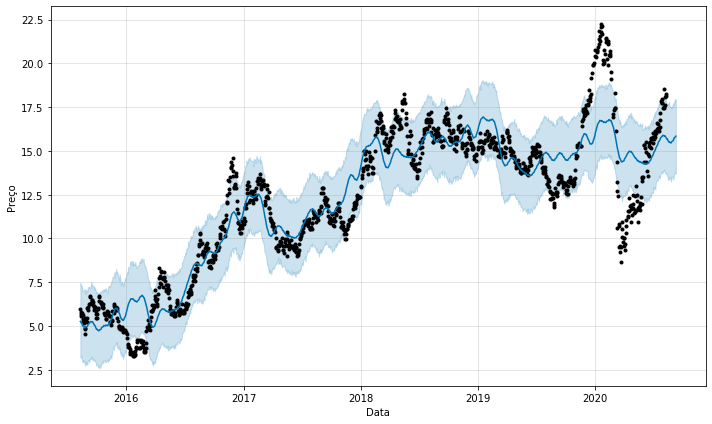

In [8]:
fig1 = m.plot(forecast, xlabel='Data', ylabel='Preço')

#### Realizando uma validação

In [9]:
df_cv = cross_validation(m, period='30 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 37 forecasts with cutoffs between 2017-02-28 00:00:00 and 2020-02-13 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-01,13.930233,13.324302,14.564566,13.30,2017-02-28
1,2017-03-02,13.999390,13.386503,14.633987,13.07,2017-02-28
2,2017-03-03,14.143384,13.489440,14.759816,13.35,2017-02-28
3,2017-03-06,14.464063,13.859389,15.084497,13.11,2017-02-28
4,2017-03-07,14.567464,13.935818,15.167343,13.02,2017-02-28


In [10]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,19 days,4.092371,2.022961,1.542437,0.110846,0.090420,0.427729
1,20 days,4.266262,2.065493,1.587521,0.114722,0.094492,0.415192
2,21 days,4.497599,2.120754,1.637640,0.118942,0.096725,0.404867
3,22 days,4.767591,2.183481,1.697536,0.122910,0.097938,0.386283
4,23 days,5.012143,2.238782,1.747635,0.126140,0.102672,0.373413


***Vamos tentar melhorar esse modelo incluindo a sazonalidade e incluindo os feriados para as analises***

#### Criando o segundo modelo Prophet com melhorias

In [11]:
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=2, daily_seasonality=True)
m.add_country_holidays(country_name='BR')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
m.fit(df)
future = m.make_future_dataframe(periods=30)
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1260,2020-09-04,18.022651,15.393537,20.678259
1261,2020-09-07,19.073548,15.915931,22.207843
1262,2020-09-08,18.097746,15.095369,21.317030
1263,2020-09-09,18.023050,14.962336,21.514822
1264,2020-09-10,17.940202,14.087822,21.551309


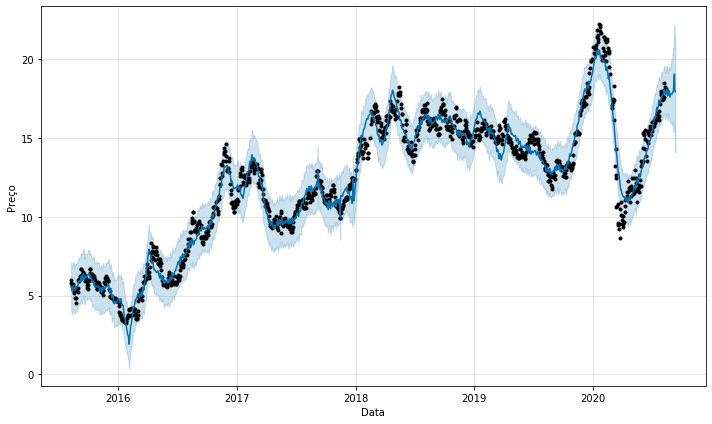

In [12]:
fig2 = m.plot(forecast, xlabel='Data', ylabel='Preço')

#### Realizando uma validação

In [13]:
df_cv = cross_validation(m, period='30 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 37 forecasts with cutoffs between 2017-02-28 00:00:00 and 2020-02-13 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-01,13.646527,13.037071,14.303694,13.30,2017-02-28
1,2017-03-02,13.575853,12.916513,14.232331,13.07,2017-02-28
2,2017-03-03,13.623105,12.954545,14.295073,13.35,2017-02-28
3,2017-03-06,14.263532,13.560211,15.077343,13.11,2017-02-28
4,2017-03-07,14.409502,13.639993,15.252150,13.02,2017-02-28


In [14]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,19 days,1.978275,1.406512,1.077806,0.078190,0.064436,0.594395
1,20 days,2.219387,1.489761,1.142731,0.083008,0.067334,0.578171
2,21 days,2.404494,1.550643,1.197888,0.086997,0.070984,0.573349
3,22 days,2.640006,1.624810,1.262763,0.091681,0.076513,0.567699
4,23 days,2.879139,1.696803,1.320274,0.096235,0.079966,0.571662


***Conseguimos melhorar bastante o modelo, vamos utilizar esse modelo em outras bases***

### Lendo a base (Histórico de preços da Rumo)

In [15]:
df_rumo = extract_data_qt('RAIL3.SA')

[*********************100%***********************]  1 of 1 completed


In [16]:
df = df_rumo[['Close']]
df['ds'] = df.index
df = df.rename(columns={"Close": "y"})

#### Criando o modelo Prophet 

In [17]:
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=2, daily_seasonality=True)
m.add_country_holidays(country_name='BR')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
m.fit(df)
future = m.make_future_dataframe(periods=30)
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1260,2020-09-04,23.240132,21.307068,25.073177
1261,2020-09-07,22.342392,20.195189,24.302404
1262,2020-09-08,23.075299,20.721368,25.104978
1263,2020-09-09,23.058364,20.777192,25.215827
1264,2020-09-10,23.056066,20.712061,25.277220


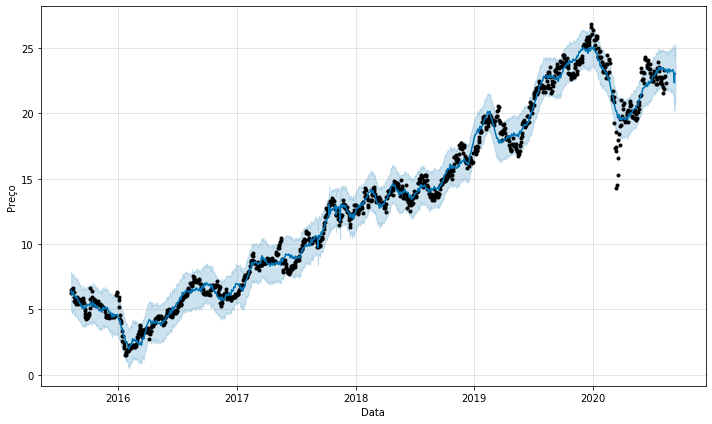

In [18]:
fig3 = m.plot(forecast, xlabel='Data', ylabel='Preço')

#### Realizando uma validação

In [19]:
df_cv = cross_validation(m, period='30 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 37 forecasts with cutoffs between 2017-02-28 00:00:00 and 2020-02-13 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-01,9.607001,9.075896,10.139054,8.49,2017-02-28
1,2017-03-02,9.634679,9.114197,10.151458,8.20,2017-02-28
2,2017-03-03,9.704314,9.179004,10.269330,8.49,2017-02-28
3,2017-03-06,10.047260,9.460609,10.686755,8.63,2017-02-28
4,2017-03-07,10.180223,9.551239,10.924350,8.40,2017-02-28


In [20]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,19 days,1.462951,1.209525,0.915589,0.059796,0.043792,0.563913
1,20 days,1.560514,1.249205,0.956260,0.062745,0.047562,0.552360
2,21 days,1.620661,1.273052,0.982714,0.064569,0.048065,0.557012
3,22 days,1.747656,1.321989,1.021763,0.067215,0.051056,0.559292
4,23 days,1.844409,1.358090,1.052797,0.069645,0.052885,0.564255


### Lendo a base (Histórico de preços da Marfrig)

In [21]:
df_marfrig = extract_data_qt('MRFG3.SA')

[*********************100%***********************]  1 of 1 completed


In [22]:
df = df_marfrig[['Close']]
df['ds'] = df.index
df = df.rename(columns={"Close": "y"})

#### Criando o modelo Prophet

In [23]:
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=2, daily_seasonality=True)
m.add_country_holidays(country_name='BR')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
m.fit(df)
future = m.make_future_dataframe(periods=30)
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1260,2020-09-04,16.017008,14.613343,17.224683
1261,2020-09-07,16.411687,14.890129,17.764671
1262,2020-09-08,16.237615,14.644027,17.576551
1263,2020-09-09,16.294586,14.812409,17.666142
1264,2020-09-10,16.360807,14.641424,17.815085


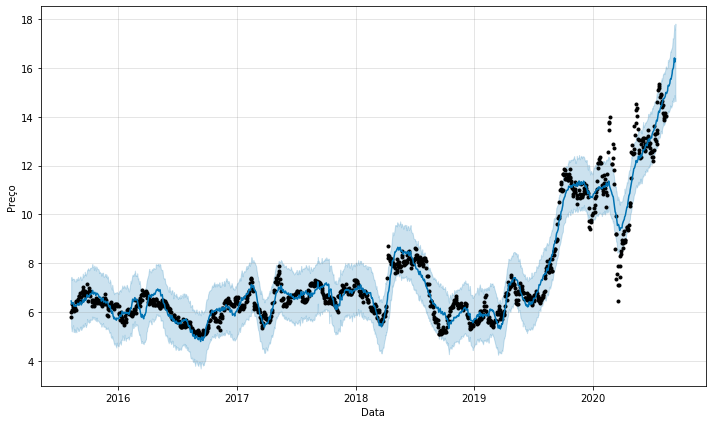

In [24]:
fig4 = m.plot(forecast, xlabel='Data', ylabel='Preço')

#### Realizando uma validação

In [25]:
df_cv = cross_validation(m, period='30 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 37 forecasts with cutoffs between 2017-02-28 00:00:00 and 2020-02-13 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-01,6.206883,5.951504,6.463342,6.29,2017-02-28
1,2017-03-02,6.127376,5.844860,6.380648,6.24,2017-02-28
2,2017-03-03,6.069645,5.739032,6.350399,6.11,2017-02-28
3,2017-03-06,6.025836,5.640804,6.334428,6.09,2017-02-28
4,2017-03-07,6.001866,5.626777,6.370459,6.07,2017-02-28


In [26]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,19 days,0.988634,0.994301,0.715179,0.093489,0.066718,0.558505
1,20 days,1.045450,1.022473,0.743888,0.097590,0.069654,0.549779
2,21 days,1.112144,1.054582,0.774282,0.101647,0.074115,0.545779
3,22 days,1.201233,1.096008,0.809102,0.106434,0.076011,0.546018
4,23 days,1.307370,1.143403,0.848657,0.111991,0.080578,0.542709
